In [1]:
#!pip install -Iv pyodbc 
import pyodbc  # gets latest version.  Needs to be at least 4.0.19 for fastwrites.
pyodbc.version

'4.0.25'

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import requests
from microsoftml import rx_logistic_regression, rx_fast_trees, rx_predict, \
                        mutualinformation_select, rx_neural_network, n_gram, \
                        categorical, categorical_hash, n_gram_hash, featurize_text
#import pyodbc
import pickle
import os
import time 
import datetime as dt
import string
from sklearn import metrics
from IPython.display import display

# custom functions
import sys
import os

from analysis_pipeline import get_match5,plot_match5,plot_acc,full_analysis

!pip install flashtext
from flashtext import KeywordProcessor

%matplotlib inline


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
def get_training_2data_():

    # reads data
    conn = pyodbc.connect(
        
        #  Connection Parameters Here
    )


    sql = """
            ### SQL Query here to fetch data
         
            """

    print('Reading Data')
    ds_hard = pd.read_sql(sql,conn)
    conn.close()

    

    return ds_hard  # return test data


In [211]:
ds_hard = get_training_2data_()


Reading Data


In [214]:
ds_hard.commodity_list.value_counts()

hard_drive                   71282
motherboard                  57498
keyboard                     22996
battery                      20580
chassis                      16847
lcd                          13982
dock                          7639
ac_adapter                    6790
mouse                         5738
cables                        5691
power_supply                  5223
heatsink                      4540
flat_panel_display            4185
wlan                          3838
operating_system              3260
fan                           3071
pcba_misc                     3013
speaker                       2838
optical_drive                 2533
memory                        2095
graphics_card                 1520
electrical_components         1287
touchpad                      1232
printer                       1015
camera                         303
mechanical_hardware            212
processor                      151
peripherals                     63
media               

In [215]:
ds_hard[ds_hard.commodity_list.str.contains('lcd')].commodity_list.value_counts()

lcd        13982
lcd(14)        1
Name: commodity_list, dtype: int64

In [216]:
ds_hard.shape

(269719, 12)

In [217]:
def data_2cleanup(ds1):
    import re
    import string
    rem = string.punctuation
    pattern = r"[{}]".format(rem)
    #pattern = pattern.replace('_', '') # makes sure that we keep the underscores
    
    # new line to be added for punctuation fix
    regex_pat = re.compile(pattern, flags=re.IGNORECASE)
    
    # Dont need this due to ngrams:
    #for each in ['product_desc', 'brand_desc']:
    #    ds1[each] = ds1[each].astype(str) + ' ' + ds1[each].str.replace(' ', '')
        
    ds1['input_data'] = ds1['X_ISP_SR_TITLE'].astype(str) + ' ' + ds1.product_desc + ' ' + ds1.brand_desc + ' ' + ds1.fmly_desc
    for col in ['X_ISP_SR_TITLE', 'product_desc', 'brand_desc', 'fmly_desc', 'input_data']:
    
        ds1[col] = ds1[col].str.lower().replace(regex_pat, ' ').apply(lambda x:  ' '.join(str(x).split()) if x else x)
    
    return ds1

In [218]:
def make_2syn_dict():
    # ----------------- Import all the stopwords/synonyms -----------------
    conn = pyodbc.connect(
##  COnnection Parameters here
    ) 
 
    sql = """
## SQL query to fetch data
"""

    syndf = pd.read_sql(sql,conn)
   
    syn_dict = dict(zip(syndf['term'].str.lower(),syndf['Replacement'].str.lower()))
    
    conn.close()
    return syn_dict

In [219]:
from collections import defaultdict

In [220]:
front_end_syn_dict = make_2syn_dict()

In [221]:
front_end_syn_dict['product key']

'activation code'

In [222]:
front_end_syn_dict['hard drive not detected'] = 'hard drive installed not working'
front_end_syn_dict['hard drive error'] = 'hard drive installed not working'
front_end_syn_dict['hard drive issue'] = 'hard drive installed not working'
front_end_syn_dict['hard drive issues'] = 'hard drive installed not working'
front_end_syn_dict['hard drive not installed'] = 'hard drive installed not working'
front_end_syn_dict['hard drive not found'] = 'hard drive installed not working'
front_end_syn_dict['no hard drive detected'] = 'hard drive installed not working'
front_end_syn_dict['hard drive password'] = 'hard drive installed not working'
front_end_syn_dict['pos hard drive'] = 'hard drive installed not working'


front_end_syn_dict['111'] = '111 CPU Exception Occurred Motherboard'
front_end_syn_dict['112'] = '112 CPU Machine Check Exception Detected Motherboard'
front_end_syn_dict['114'] = '114 CPU Cache Integrity Test Discrepancy Motherboard'
front_end_syn_dict['115'] = '115 CPU Stress Thermal Condition Limit Motherboard'
front_end_syn_dict['122'] = '122 Memory errors detected. Too many errors, issue cannotbe resolved Memory'
front_end_syn_dict['123'] = '123 Memory- integrity test discrepancy Motherboard'
front_end_syn_dict['125'] = '125 ECC errors have occurred Memory'
front_end_syn_dict['126'] = '126 The event log(s) must be cleared before testing can continue Memory'
front_end_syn_dict['131'] = '131 Battery - The battery is not installed Battery (Notebook)'
front_end_syn_dict['132'] = '132 Battery -The battery is reaching the end of its usable life Battery (Notebook)'
front_end_syn_dict['133'] = '133 Battery - The battery cannot provide sufficient power Battery (Notebook)'
front_end_syn_dict['134'] = '134 Charger -Charge cycles exceeded maximum limit Battery (Notebook)'
front_end_syn_dict['141'] = '141 Hard Drive - no drive detected Hard Drive'
front_end_syn_dict['142'] = '142 A. Hard Drive self-test unsuccessful, terminated'
front_end_syn_dict['143'] = '143 Your hard disk drive has indicated a failure.'
front_end_syn_dict['144'] = '144 Your hard disk drive has indicated a failure.'
front_end_syn_dict['145'] = '145 Hard Drive - self test did not complete Hard Drive'
front_end_syn_dict['146'] = '146 Hard Drive - self test log contains previous errors Hard Drive'
front_end_syn_dict['147'] = '147 Optical Drive - self test error Motherboard'
front_end_syn_dict['150'] = '150 Hard Drive - No drive detected Hard Drive'
front_end_syn_dict['151'] = '151 Hard Drive - incorrect status  Hard Drive'
front_end_syn_dict['152'] = '152 Optical Drive - incorrect status  Motherboard'
front_end_syn_dict['155'] = '155 Hard Drive not installed Hard Drive'
front_end_syn_dict['156'] = '156 eMMC Long and Short Read Test failed Motherboard'
front_end_syn_dict['161'] = '161 Replace the Optane SSD'
front_end_syn_dict['213'] = '213 System board - CMOS battery failure detected Motherboard'
front_end_syn_dict['221'] = '221 Timer - Interval timer not functional Motherboard'
front_end_syn_dict['233'] = '233 System board - RTC seconds count is not updating Motherboard'
front_end_syn_dict['234'] = '234 System board - HPET, incorrect time period Motherboard'
front_end_syn_dict['241'] = '241 BIOS - A20 gate not enabled Motherboard'
front_end_syn_dict['242'] = '242 System board - Interrupt controller, IRQ not detected Motherboard'
front_end_syn_dict['243'] = '243 USB Device Error Motherboard'
front_end_syn_dict['244'] = '244 USB Device Error Motherboard'
front_end_syn_dict['245'] = '245 USB Device Error Motherboard'
front_end_syn_dict['261'] = '261 System Board Data Errors Motherboard'
front_end_syn_dict['313'] = '313 Touchpad - pointing stick/touchpad not detected Motherboard'
front_end_syn_dict['314'] = '314 Thermal: Temperature exceeds the thermal limit Motherboard'
front_end_syn_dict['315'] = '315 Sensor: Temperature is lower than expected Motherboard'
front_end_syn_dict['321'] = '321 LCD EDID - unable to access EDID EEPROM Motherboard'
front_end_syn_dict['322'] = '322 LCD panel - unable to modify brightness LCD Panel'
front_end_syn_dict['324'] = '324 LCD panel - user reported LCD BIST colors were not displayed LCD Panel'
front_end_syn_dict['325'] = '325 LCD panel - user provided no input for LCD BIST LCD Panel'
front_end_syn_dict['326'] = '326 LCD panel - unable to turn lamp on or off LCD Panel'
front_end_syn_dict['327'] = '327 LCD panel - unable to use BIOS interface Motherboard'
front_end_syn_dict['328'] = '328 LCD panel - unable to detect variance in ambient light sensor LCD Panel'
front_end_syn_dict['331'] = '331 Video controller - no video controller detected Motherboard'
front_end_syn_dict['332'] = '332 Video memory -Video memory integrity test discrepancy Motherboard'
front_end_syn_dict['333'] = '333 Video - User provided no input for graphics test Motherboard'
front_end_syn_dict['334'] = '334 Video - user reported the patterns were not displayed LCD Panel'
front_end_syn_dict['415'] = '415 LCD Cable Error LCD Panel'
front_end_syn_dict['511'] = '511 Fan - The fan failed to respond correctly Motherboard'
front_end_syn_dict['512'] = '512 Fan - The fan is running faster than expected Motherboard'
front_end_syn_dict['620'] = '620 Network Controller Error Motherboard'
front_end_syn_dict['621'] = '621 Network Controller Error Motherboard'
front_end_syn_dict['8011'] = '8011  USB Device Error Motherboard'
front_end_syn_dict['8012'] = '8012 USB Device Error Motherboard'


In [223]:
def synonymn_2func_batch(batch_titles, syn_dict):
# Jaya's fast synonym replacement

    
    # ----------------- Finished Import --------------------------
    
    keydict = {}
    
    keyword_processor = KeywordProcessor()
    multiword_processor = KeywordProcessor()
    extractor = KeywordProcessor()
    
    for key, val in syn_dict.items():
        if len(key.split()) == 1:    
            keyword_processor.add_keyword(key, val)
        elif len(key.split()) > 1:
            multiword_processor.add_keyword(key, val)
    
    
    # Loop through the 2 synonymn replacing functions and extract keywords
    return [multiword_processor.replace_keywords(keyword_processor.replace_keywords(each_title)) 
            for each_title in batch_titles]

In [225]:
df_hard = data_2cleanup(ds_hard)
df_hard['input_data'] = synonymn_2func_batch(df_hard['input_data'].values, front_end_syn_dict)

In [226]:
def remove_2punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text


In [227]:
#Removing punctuations
df_hard["input_data"] = df_hard['input_data'].apply(remove_2punctuations)

In [228]:
df_hard.commodity_list.value_counts()

hard_drive                   71282
motherboard                  57498
keyboard                     22996
battery                      20580
chassis                      16847
lcd                          13982
dock                          7639
ac_adapter                    6790
mouse                         5738
cables                        5691
power_supply                  5223
heatsink                      4540
flat_panel_display            4185
wlan                          3838
operating_system              3260
fan                           3071
pcba_misc                     3013
speaker                       2838
optical_drive                 2533
memory                        2095
graphics_card                 1520
electrical_components         1287
touchpad                      1232
printer                       1015
camera                         303
mechanical_hardware            212
processor                      151
peripherals                     63
media               

In [229]:
def remove_2less_than_n_from_column(ds1, n, column_to_filter):
    no_values_list = ds1[column_to_filter].value_counts()[ds1[column_to_filter].value_counts()<n].reset_index()['index'].values
    print("{} that only show up less than {} times:".format(column_to_filter, n), no_values_list)
    print()
    no_values_index = ds1[column_to_filter].apply(lambda x: x not in no_values_list)
    filtered_ds1 = ds1.ix[no_values_index].reset_index(drop=True)
    print("Dropping rows with nulls in column '{}'".format(column_to_filter))
    print()
    filtered_ds1 = filtered_ds1.dropna(axis=0, subset=[column_to_filter]).reset_index(drop=True)
    print("old data shape: ", ds1.shape, "new data shape: ", filtered_ds1.shape)
    return filtered_ds1

hard_drive                   71282
motherboard                  57498
keyboard                     22996
battery                      20580
chassis                      16847
lcd                          13982
dock                          7639
ac_adapter                    6790
mouse                         5738
cables                        5691
power_supply                  5223
heatsink                      4540
flat_panel_display            4185
wlan                          3838
operating_system              3260
fan                           3071
pcba_misc                     3013
speaker                       2838
optical_drive                 2533
memory                        2095
graphics_card                 1520
electrical_components         1287
touchpad                      1232
printer                       1015
camera                         303
mechanical_hardware            212
processor                      151
peripherals                     63
media               

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


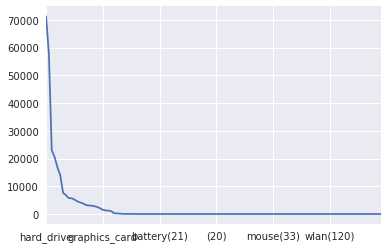

In [230]:
df_hard['commodity_list'].value_counts().plot()
df_hard['commodity_list'].value_counts()

In [231]:
# how many hard fix categories are there?
len(df_hard['commodity_list'].value_counts())

119

In [232]:
# how many if we limit to a decent volume?
len(df_hard['commodity_list'].value_counts()[df_hard['commodity_list'].value_counts()>50])

29

In [233]:
df_hard = remove_2less_than_n_from_column(df_hard, 50, 'commodity_list')

commodity_list that only show up less than 50 times: ['network_card' 'service' 'chassis(15)' 'chassis(23)' 'chassis(25)'
 'microphone' 'chassis(16)' 'chassis(20)' 'chassis(22)' 'cables(15)'
 'wlan(100)' 'battery(21)' 'chassis(40)' 'wlan(35)' 'chassis(24)'
 'chassis(50)' 'wlan(31)' 'battery(50)' 'chassis(17)' 'chassis(14)'
 'battery(20)' 'wlan(25)' 'wlan(50)' 'mouse(15)' 'battery(40)'
 'chassis(80)' 'hard_drive(20)' 'wlan(20)' 'wlan(15)' 'wlan(71)'
 'wlan(38)' '(20)' 'cables(18)' 'flat_panel_display(25)' 'keyboard(15)'
 'wlan(90)' 'cables(50)' 'scanner' 'chassis(30)' 'chassis(62)'
 'chassis(32)' 'cables(20)' '(125)' 'dock(15)' 'modem' 'battery(140)'
 'battery(18)' 'wlan(78)' 'motherboard(44)' 'cables(22)' 'chassis(44)'
 'mouse(33)' 'hard_drive(16)' 'battery(14)' 'chassis(19)' 'chassis(72)'
 'electrical_components(64)' 'keyboard(34)' 'battery(29)' 'battery(27)'
 'wlan(65)' 'lcd(14)' 'motherboard(17)' 'battery(136)' 'pcba_misc(20)'
 'power_supply(17)' 'wlan(55)' 'electrical_components(40)

In [235]:
df_hard["commodity_list"] = df_hard["commodity_list"].astype("category")
df_hard["brand_desc"] = df_hard["brand_desc"].astype("category")
df_hard["fmly_desc"] = df_hard["fmly_desc"].astype("category")
df_hard["lob_desc"] = df_hard["product_desc"].astype("category")
#df_hard['gsd_tower'] = df_hard['gsd_tower'].astype('category')

In [236]:
df_hard.commodity_list.nunique()

29

In [237]:
df_validation=df_hard[df_hard.fweek.isin([201923,201924,201925,201926])].reset_index(drop=True)

In [238]:
df_hard=df_hard[~df_hard.fweek.isin([201923,201924,201925,201926])].reset_index(drop=True)

In [240]:
df_validation.fweek.value_counts()

201923.0    8717
201925.0    8599
201926.0    8501
201924.0    8483
Name: fweek, dtype: int64

In [241]:
# split data between training and test
from sklearn import  model_selection

sssplit = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

sss = sssplit.get_n_splits(df_hard, df_hard['commodity_list'])

In [242]:
for train_index, test_index in sssplit.split(np.zeros(df_hard.shape[0]), df_hard['commodity_list']):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test_all = df_hard.ix[train_index].reset_index(), df_hard.ix[test_index].reset_index()
    y_train, y_test_all =  df_hard['commodity_list'][train_index].reset_index(drop=True), \
                           df_hard['commodity_list'][test_index].reset_index(drop=True)

TRAIN: [172813 152249  16445 ... 210370  86187 225426] TEST: [ 53672 193827 120827 ... 101339 118077  67553]


In [243]:
X_test_all.shape, X_train.shape

((94070, 15), (141103, 15))

In [245]:
# Score 
def score_2log_reg_hard(model, test_ds1):
    # score and have it rtn enough fields to join back to orig dataset
    scoreAutoRec = rx_predict(model, data = test_ds1, extra_vars_to_write=["dispatch_id","commodity_list"])  

    return scoreAutoRec

In [246]:
import numpy

In [247]:
# Eval 

def eval_2log_reg_hd(scored_data):
  
  #  sc = scoreAutoRec_tree_test
    sc =  scored_data
    #sc.head()
    sc_score_cats = list(sc.commodity_list.cat.categories)
    sc_scores_only = sc.loc[:, sc.columns.str.startswith('Score')]    # get columns that start with Score

    sc_scores_only.columns = sc.commodity_list.cat.categories  # set column names equal to predicted names

    pred_col = sc_scores_only.idxmax(axis=1)  # gets column label with max score
    sc_scores_only['predicted_label'] = pred_col

    pred_score = sc_scores_only.max(axis=1)  # Randi's idea   
    sc_scores_only['predicted_score'] = pred_score
    #print(sc_scores_only['predicted_score'].head())

    scored = sc_scores_only  
    scored['commodity_list'] = sc.commodity_list

    print(metrics.classification_report(scored.commodity_list, scored.predicted_label))
    
    badPrediction = scored.commodity_list != scored.predicted_label
    
    # prediction IS IN resolution list
    #scored['commodity_inmatch'] = numpy.zeros((scored.commodity_list.shape[0], 1))
    commodity_inmatch = defaultdict(lambda:0)
    for i,commodity_list in enumerate(scored.commodity_list):
        if (scored['predicted_score'].iloc[i]>0.95) \
                & (str(scored['predicted_label'].iloc[i]) in str(commodity_list)):
            commodity_inmatch[commodity_list] += 1
            #scored['commodity_inmatch'].iloc[i] = 1
            

    print(commodity_inmatch)
    
    #sc = pd.DataFrame ({ 'dispatch_id':sc.dispatch_id, 'predicted_label':sc_scores_only['predicted_label'], 
    #                     'score' :sc_scores_only['predicted_score'] })  
    
    return scored

In [248]:
from matplotlib import pyplot as plt

In [249]:
col_to_use = ['sr_num','lob_desc','brand_desc', 'fmly_desc','commodity_list', "X_ISP_SR_TITLE", "input_data",'commodity_standardized_num_parts' ]

In [250]:
X_test_all.shape

(94070, 15)

# Startified Cross validation

#### We will be running GridSearch with Stratified Cross Validation on train data to find out optimize value for lr__C.

In [252]:
from sklearn.model_selection import StratifiedKFold

In [326]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for f, split in enumerate(skf.split(X_train, X_train['commodity_list'])):
    print("Fold", f + 1, "-----")
    test = X_train.iloc[split[1]]
    print("Commodity Distribution:", test['commodity_list'].value_counts(normalize=True), "", sep='\n')

Fold 1 -----
Commodity Distribution:
hard_drive               0.268242
motherboard              0.210612
keyboard                 0.086320
battery                  0.073675
chassis                  0.063014
lcd                      0.051608
dock                     0.027168
ac_adapter               0.024865
mouse                    0.022846
cables                   0.021536
power_supply             0.019729
heatsink                 0.016506
flat_panel_display       0.015125
wlan                     0.014204
operating_system         0.012397
fan                      0.011335
pcba_misc                0.011122
speaker                  0.010555
optical_drive            0.009564
memory                   0.007615
graphics_card            0.005703
electrical_components    0.004853
touchpad                 0.004605
printer                  0.003825
camera                   0.001133
mechanical_hardware      0.000779
processor                0.000602
peripherals              0.000248
media      

In [254]:
import nltk
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('lr', LogisticRegression())
])

analyzer = TfidfVectorizer().build_analyzer()
#stemmer = nltk.stem.SnowballStemmer('english')

pipeline.set_params(
    #tfidf__analyzer=lambda x: (stemmer.stem(w) for w in analyzer(x)),
    tfidf__ngram_range=(1,2),
    lr__solver='sag',
    lr__multi_class='multinomial',
    lr__penalty='l2', 
    lr__tol=0.001, 
    lr__verbose=False)

param_grid = {
    'lr__C': np.linspace(1, 3, 11) # I think the value is close to 2 based on previous testing, and want to reduce runtime
}


In [47]:
gs = GridSearchCV(
    pipeline, 
    param_grid=param_grid,
    cv=skf,
    verbose=1,
    return_train_score=False)

gs.fit(X_train['input_data'], y=X_train['commodity_list'])
print("Best C:", gs.best_params_['lr__C'])

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).ty

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).ty

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).ty

Best C: 3.0


In [255]:
gs.best_params_['lr__C']

3.0

#### Setting  lr__C parameter

In [256]:
pipeline.set_params(lr__C=gs.best_params_['lr__C'])

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=False, warm_start=False))])

In [257]:
from sklearn.model_selection import cross_val_score

In [258]:


print("Running stratified k-fold...", end='')
skf_results = cross_val_score(
    pipeline, 
    X=X_train['input_data'], 
    y=X_train['commodity_list'], 
    cv=skf, 
   # return_train_score=False, 
    verbose=False)
print(" done.")


Running stratified k-fold...

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).ty

 done.


In [259]:
print("Stratified k-fold average accuracy:", np.mean(skf_results))

Stratified k-fold average accuracy: 0.8461761192341131


### Now I'll fit the same pipeline on the entire train set and then predict on the test set.

In [260]:
auto_rec_model=pipeline.fit(X_train['input_data'], y=X_train['commodity_list'])

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [261]:
#test_pred = pipeline.fit(X_train['input_data'], y=X_train['commodity_list']).predict(X_test_all['input_data'])
test_pred = auto_rec_model.predict(X_test_all['input_data'])

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [262]:
#test_perc = pipeline.fit(X_train['input_data'], y=X_train['commodity_list']).predict_proba(X_test_all['input_data'])
test_perc = auto_rec_model.predict_proba(X_test_all['input_data'])

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [336]:
test_perc

array([[2.96113630e-02, 2.14698385e-02, 2.44391857e-02, ...,
        1.74060817e-02, 1.28733972e-02, 1.56173923e-02],
       [1.43087438e-02, 1.14116241e-02, 7.95288231e-02, ...,
        3.24119123e-03, 1.99146891e-04, 4.75565325e-04],
       [9.39670756e-03, 9.49493271e-01, 7.79465689e-03, ...,
        2.62894898e-04, 1.01815115e-05, 4.99478271e-05],
       ...,
       [8.15574636e-04, 3.61439027e-03, 2.43516118e-03, ...,
        1.29748376e-03, 8.92057329e-05, 9.18915101e-04],
       [8.89745344e-04, 4.32488590e-03, 1.78356257e-03, ...,
        6.07106252e-04, 3.51565873e-05, 1.82602344e-03],
       [2.49401024e-04, 9.24250013e-05, 2.54375855e-04, ...,
        1.72345179e-05, 3.82026594e-05, 5.08024201e-05]])

In [337]:
pipeline.classes_

array(['ac_adapter', 'battery', 'cables', 'camera', 'chassis', 'dock',
       'electrical_components', 'fan', 'flat_panel_display',
       'graphics_card', 'hard_drive', 'heatsink', 'keyboard', 'lcd',
       'mechanical_hardware', 'media', 'memory', 'motherboard', 'mouse',
       'operating_system', 'optical_drive', 'pcba_misc', 'peripherals',
       'power_supply', 'printer', 'processor', 'speaker', 'touchpad',
       'wlan'], dtype=object)

In [339]:
scoreAutoRec_hd=pd.DataFrame(test_perc,columns=pipeline.classes_)

In [340]:
scoreAutoRec_hd['predicted_label']=scoreAutoRec_hd.idxmax(axis=1)

In [341]:
scoreAutoRec_hd['predicted_score']=scoreAutoRec_hd.loc[:,scoreAutoRec_hd.columns!='predicted_label'].apply(max, axis=1)
#scoreAutoRec.loc[:, scoreAutoRec.columns.str.startswith('Score.')].apply(max, axis=1)

In [342]:
test_pred

array(['hard_drive', 'flat_panel_display', 'battery', ..., 'hard_drive',
       'hard_drive', 'keyboard'], dtype=object)

In [343]:
scoreAutoRec_hd['PredictedLabel']=test_pred
scoreAutoRec_hd['commodity_list']=X_test_all['commodity_list']
scoreAutoRec_hd['sr_num']=X_test_all['sr_num']

In [344]:
scoreAutoRec_hd.head()

,ac_adapter,battery,cables,camera,chassis,dock,electrical_components,fan,flat_panel_display,graphics_card,...,printer,processor,speaker,touchpad,wlan,predicted_label,predicted_score,PredictedLabel,commodity_list,sr_num
0,0.029611,0.021470,0.024439,0.001920,0.030865,0.002687,0.001431,0.003257,0.000967,0.000673,...,0.000656,0.000907,0.017406,0.012873,0.015617,hard_drive,0.415490,hard_drive,motherboard,965842293
1,0.014309,0.011412,0.079529,0.000312,0.001602,0.293337,0.037642,0.000360,0.470534,0.001428,...,0.001183,0.000322,0.003241,0.000199,0.000476,flat_panel_display,0.470534,flat_panel_display,dock,963615047
2,0.009397,0.949493,0.007795,0.000057,0.001314,0.000198,0.000083,0.000047,0.000038,0.000016,...,0.000016,0.000014,0.000263,0.000010,0.000050,battery,0.949493,battery,battery,961395475
3,0.000691,0.001901,0.000397,0.000101,0.034445,0.002591,0.000144,0.000277,0.000060,0.000021,...,0.000031,0.000023,0.000614,0.000020,0.000851,keyboard,0.933418,keyboard,keyboard,963099985
4,0.001254,0.000759,0.003553,0.000043,0.000503,0.000225,0.000055,0.000111,0.000020,0.000018,...,0.000017,0.000019,0.000046,0.000014,0.001087,motherboard,0.988484,motherboard,motherboard,968098252


In [345]:
# prediction is exact match
matches = scoreAutoRec_hd[scoreAutoRec_hd['commodity_list'].astype('object')\
                                 ==scoreAutoRec_hd['PredictedLabel'].astype('object')]
num_match=len(matches['PredictedLabel'])
num_tot = len(scoreAutoRec_hd)
num_match/num_tot

0.8466992665036674

In [346]:
scoreAutoRec_hd[(scoreAutoRec_hd.predicted_score>=0.95)].predicted_label.value_counts()

hard_drive               18093
keyboard                  5917
motherboard               4953
battery                   3803
chassis                   2358
mouse                     1537
lcd                       1157
dock                      1093
flat_panel_display         695
optical_drive              551
heatsink                   518
wlan                       409
power_supply               369
ac_adapter                 358
speaker                    288
cables                     223
printer                    130
fan                        124
memory                      78
graphics_card               60
operating_system            40
electrical_components       37
touchpad                    17
pcba_misc                    4
camera                       2
Name: predicted_label, dtype: int64

In [347]:
scoreAutoRec_hd[(scoreAutoRec_hd['commodity_list'].astype('object')==scoreAutoRec_hd['predicted_label'].astype('object')) & (scoreAutoRec_hd.predicted_score>=0.95)].predicted_label.value_counts()

hard_drive               17922
keyboard                  5828
motherboard               4826
battery                   3731
chassis                   2319
mouse                     1517
lcd                       1106
dock                      1038
flat_panel_display         681
optical_drive              544
heatsink                   514
wlan                       395
power_supply               366
ac_adapter                 351
speaker                    271
cables                     219
printer                    129
fan                        119
memory                      72
graphics_card               60
operating_system            37
electrical_components       37
touchpad                    17
pcba_misc                    3
camera                       2
Name: predicted_label, dtype: int64

In [348]:
scoreAutoRec_hd.predicted_label.value_counts()

hard_drive               26501
motherboard              21777
keyboard                  7894
battery                   6951
chassis                   5951
lcd                       4957
dock                      2563
ac_adapter                2249
mouse                     2137
power_supply              1691
flat_panel_display        1439
heatsink                  1413
wlan                      1272
cables                    1103
fan                       1052
speaker                    958
optical_drive              820
operating_system           675
pcba_misc                  671
graphics_card              419
printer                    417
touchpad                   362
memory                     360
electrical_components      332
camera                      89
mechanical_hardware         10
processor                    5
peripherals                  2
Name: predicted_label, dtype: int64

In [277]:
scoreAutoRec_hd.shape

(94070, 34)

### Validate on 201923 to 201926 data

In [278]:
validate_pred = auto_rec_model.predict(df_validation['input_data'])

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [279]:
len(validate_pred)

34300

In [280]:
validate_rest = pd.DataFrame(columns=['PredictedLabel','commodity_list'])

In [281]:
validate_rest['PredictedLabel']=validate_pred
validate_rest['commodity_list']=df_validation['commodity_list']

In [282]:
len(validate_rest)

34300

In [283]:
# prediction is exact match
matches = validate_rest[validate_rest['commodity_list'].astype('object')\
                                 ==validate_rest['PredictedLabel'].astype('object')]
num_match=len(matches['PredictedLabel'])
num_tot = len(validate_rest)
num_match/num_tot

0.8541399416909621

In [351]:
def print_2predictions(test_rest):
    col_names =  ['commodity', 'correctly_classified','correctly_classified%','incorrectly_classified','incorrectly_classified%','missed_detections','missed_detections%']
    my_df  = pd.DataFrame(columns = col_names)
    for i, each in enumerate(test_rest.PredictedLabel.unique()):
        print("commodity = ", each)

        #sc[each].hist(bins=100)
        #plt.show()
        #sc[sc['predicted_label'] == each].predicted_score.hist(bins=10)
        #plt.show()
    #     sc[(sc['predicted_label'] == each) & (sc['commodity_list'] == each)].predicted_score.hist(bins=20)
    #     plt.title("Correctly classifying - scores for {}".format(each))
    #     plt.show()
    #     sc[(sc['predicted_label'] == each) & (sc['commodity_list'] != each)].predicted_score.hist(bins=20)
    #     plt.title("Incorrectly classifying - scores for {}".format(each))
    #     plt.show()

        correct_num =  ((test_rest['PredictedLabel'] == each) & (test_rest['commodity_list'] == each)).sum()
        incorrect_num = ((test_rest['PredictedLabel'] == each) & (test_rest['commodity_list'] != each)).sum()
        incorrect_num_miss = ((test_rest['PredictedLabel'] != each) & (test_rest['commodity_list'] == each)).sum()

        print("correctly classified : ", correct_num,',', correct_num/(test_rest['commodity_list'] == each).sum())
        print("incorrectly classified : ", incorrect_num,',', incorrect_num/(test_rest['commodity_list'] != each).sum())
        print("missed detections : ", incorrect_num_miss,',', incorrect_num_miss/(test_rest['commodity_list'] == each).sum())

        print("------------------------------")
        my_df = my_df.append({'commodity':each,'correctly_classified':correct_num,'correctly_classified%':(correct_num/(test_rest['commodity_list'] == each).sum()),\
                                          'incorrectly_classified':incorrect_num,'incorrectly_classified%':(incorrect_num/(test_rest['commodity_list'] != each).sum()),\
                                         'missed_detections':incorrect_num_miss,'missed_detections%':(incorrect_num_miss/(test_rest['commodity_list'] == each).sum())\
                                         }, ignore_index=True)
    return my_df

In [350]:
results=print_2predictions(scoreAutoRec_hd)

commodity =  hard_drive
correctly classified :  23816 , 0.9435442335882097
incorrectly classified :  2685 , 0.039009719740225775
missed detections :  1425 , 0.05645576641179034
------------------------------
commodity =  flat_panel_display
correctly classified :  1279 , 0.8981741573033708
incorrectly classified :  160 , 0.001727003864171146
missed detections :  145 , 0.10182584269662921
------------------------------
commodity =  battery
correctly classified :  6143 , 0.8859244303432362
incorrectly classified :  808 , 0.009272860815277268
missed detections :  791 , 0.11407556965676377
------------------------------
commodity =  keyboard
correctly classified :  7463 , 0.91886234917508
incorrectly classified :  431 , 0.0050146600269930655
missed detections :  659 , 0.08113765082491997
------------------------------
commodity =  motherboard
correctly classified :  16557 , 0.8353683148335015
incorrectly classified :  5220 , 0.0703030303030303
missed detections :  3263 , 0.16463168516649848

In [301]:
results.to_csv("PRedictive_Results_Cross_validation_16012019.csv")

## Confusion Matrix

In [302]:
from sklearn.metrics import confusion_matrix

In [303]:
cm = pd.DataFrame(confusion_matrix(scoreAutoRec_hd.commodity_list,scoreAutoRec_hd.predicted_label,labels=list(scoreAutoRec_hd.commodity_list.unique())),
             columns = list(scoreAutoRec_hd.commodity_list.unique()),
             index = list(scoreAutoRec_hd.commodity_list.unique()))

In [305]:
cm.to_csv('Confusion_Matrix_TestData_Cross_validation.csv')

In [306]:
cm.sum(axis = 1)

motherboard              19820
dock                      2555
battery                   6934
keyboard                  8122
hard_drive               25241
electrical_components      455
chassis                   5929
power_supply              1857
heatsink                  1550
cables                    2026
flat_panel_display        1424
lcd                       4855
pcba_misc                 1045
ac_adapter                2339
fan                       1067
touchpad                   431
wlan                      1335
mouse                     2149
speaker                    992
optical_drive              898
graphics_card              536
mechanical_hardware         70
operating_system          1166
memory                     715
printer                    360
processor                   54
camera                     105
peripherals                 20
media                       20
dtype: int64

In [307]:
from matplotlib import pyplot as plt

In [308]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [309]:
comm_list=sorted(list(scoreAutoRec_hd.commodity_list.unique()))
comm_list.append('avg / tota')

In [310]:
comm_list = pd.Series(comm_list)

In [311]:
def pandas_2classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

In [312]:
print(classification_report(y_true=scoreAutoRec_hd.commodity_list, y_pred=scoreAutoRec_hd.predicted_label, digits=6))

                       precision    recall  f1-score   support

           ac_adapter   0.759449  0.730227  0.744551      2339
              battery   0.883758  0.885924  0.884840      6934
               cables   0.722575  0.393386  0.509428      2026
               camera   0.775281  0.657143  0.711340       105
              chassis   0.857839  0.861022  0.859428      5929
                 dock   0.874756  0.877495  0.876123      2555
electrical_components   0.813253  0.593407  0.686150       455
                  fan   0.816540  0.805061  0.810760      1067
   flat_panel_display   0.888812  0.898174  0.893468      1424
        graphics_card   0.804296  0.628731  0.705759       536
           hard_drive   0.898683  0.943544  0.920567     25241
             heatsink   0.874735  0.797419  0.834290      1550
             keyboard   0.945402  0.918862  0.931943      8122
                  lcd   0.805729  0.822657  0.814105      4855
  mechanical_hardware   0.900000  0.128571  0.225000  

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [313]:
df_class_report = pandas_2classification_report(y_true=scoreAutoRec_hd.commodity_list, y_pred=scoreAutoRec_hd.predicted_label)

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [314]:
df_class_report['commodities'] = comm_list.values
df_class_report.reset_index(drop=True)

,precision,recall,f1-score,support,commodities
0,0.759449,0.730227,0.744551,2339.0,ac_adapter
1,0.883758,0.885924,0.884840,6934.0,battery
2,0.722575,0.393386,0.509428,2026.0,cables
3,0.775281,0.657143,0.711340,105.0,camera
4,0.857839,0.861022,0.859428,5929.0,chassis
5,0.874756,0.877495,0.876123,2555.0,dock
6,0.813253,0.593407,0.686150,455.0,electrical_components
7,0.816540,0.805061,0.810760,1067.0,fan
8,0.888812,0.898174,0.893468,1424.0,flat_panel_display
9,0.804296,0.628731,0.705759,536.0,graphics_card


In [315]:
df_class_report.to_csv('Precision_Recall_Matrix_Testdata_Cross_Validation.csv')

/opt/microsoft/mlserver/9.2.1/runtime/python/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


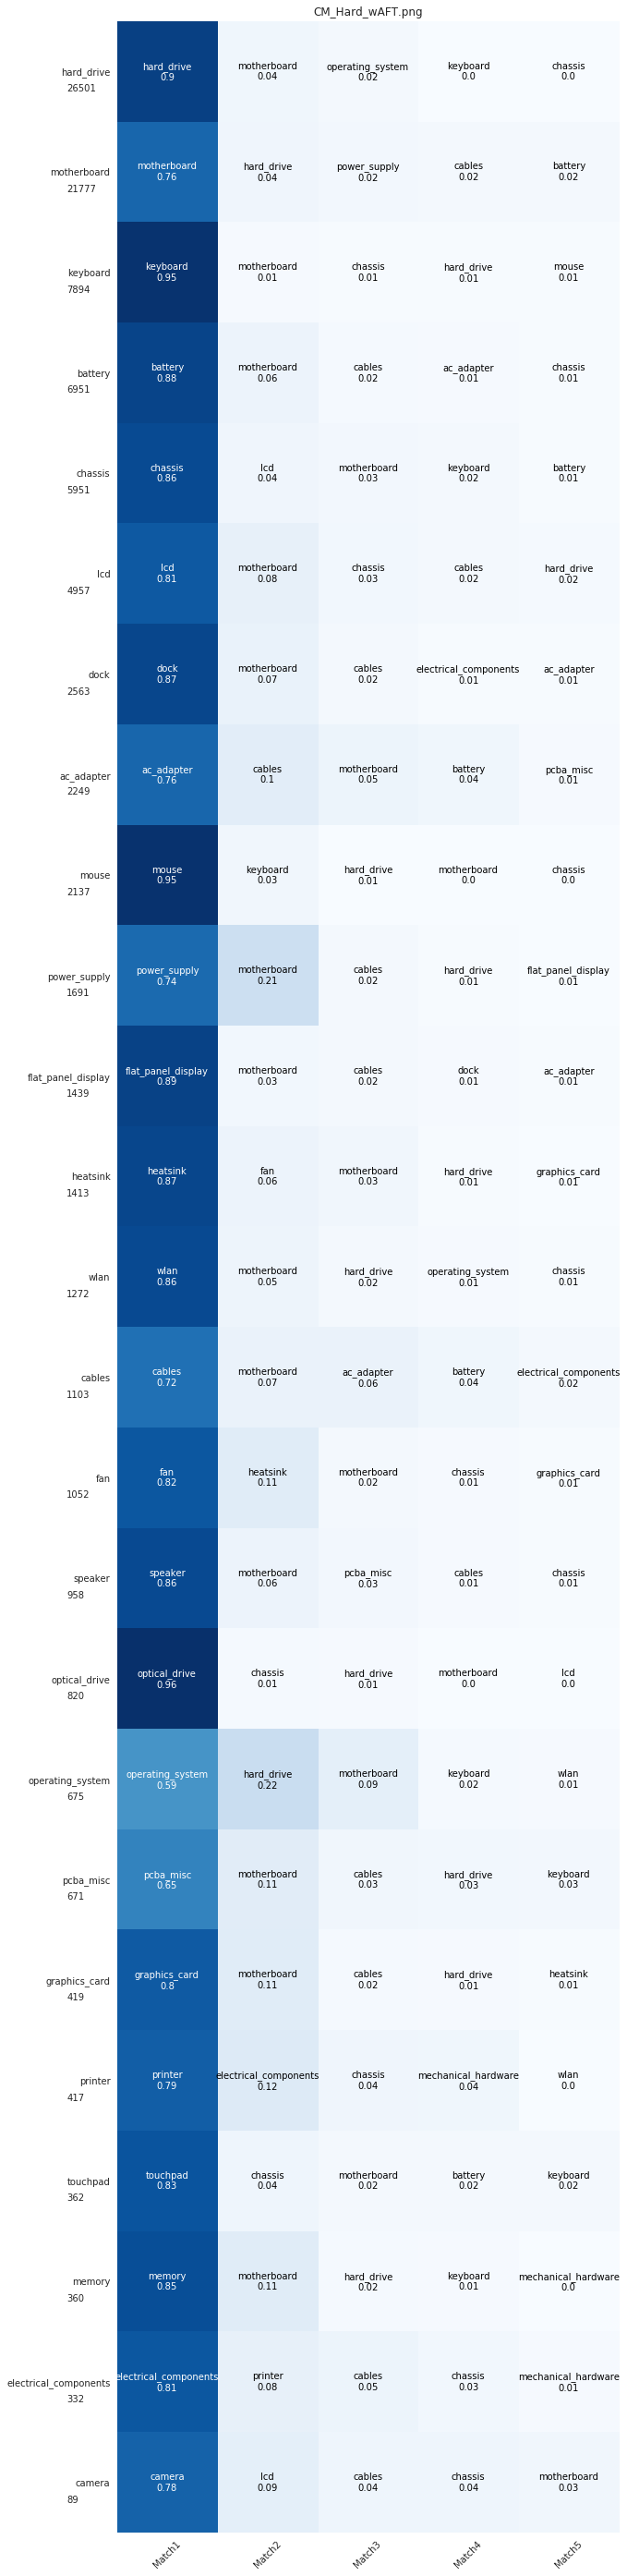

In [316]:
match5 = get_match5(scoreAutoRec_hd['commodity_list'],scoreAutoRec_hd['predicted_label'])
numrows = 25
cmplotname = ('CM_Hard_wAFT.png')
plot_match5(match5,numrows,cmplotname)

## Notebook Information:

In [317]:
## Notebook Information:


import os
from IPython.core.display import Javascript
from IPython.display import display
import datetime
display(Javascript('Jupyter.notebook.kernel.execute(\
                       "this_notebook = " + "\'"\
                       +Jupyter.notebook.notebook_name+"\'");'))

<IPython.core.display.Javascript object>

In [318]:
NOTEBOOK_NAME = this_notebook.split('.')[0]
print(NOTEBOOK_NAME)


Hard_Model_Single_Commodity_StratifiedCrossValidaation_Cparameter_Tunning_Harshal_2


In [320]:
pkl_filename =  NOTEBOOK_NAME +'_time_' + datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d_%H%S') + '.pkl'

print(pkl_filename)

Hard_Model_Single_Commodity_StratifiedCrossValidaation_Cparameter_Tunning_Harshal_2_time_20190116_1553.pkl


In [324]:
from sklearn.externals import joblib

In [325]:
joblib.dump(auto_rec_model, pkl_filename) 

['Hard_Model_Single_Commodity_StratifiedCrossValidaation_Cparameter_Tunning_Harshal_2_time_20190116_1553.pkl']

In [208]:
auto_rec_model.steps[1][1]


LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=False, warm_start=False)

In [209]:
auto_rec_model.steps[0]

('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None))